### Przygotowanie do analizy

In [1]:
!pip install pandas matplotlib seaborn scikit-learn tensorflow

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

SESSIONS = "./V1/sessions.jsonl"
ARTISTS = "./V1/artists.jsonl"
TRACKS = "./V1/tracks.jsonl"
USERS = "./V1/users.jsonl"

2025-01-16 00:35:01.760057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 00:35:03.283887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 00:35:03.288038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 00:35:06.177517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Model zaawansowany 

Model zaawansowany będzie implementacją neuronowej sieci rekurencyjnej (RNN) w wariancie Long Short-Term Memory (LSTM). Zaimplementowany będzie za pomocą modelu Sequential LSTM z biblioteki tensorflow.keras.

Wejście:
- wartość popularity_score w poprzednich tygodniach
- id artysty (id_artist_numeric) - (korelacja: 0.21)
- duration_ms - (korelacja: 0.08)
- danceability - (korelacja: 0.14)
- energy - (korelacja: 0.06)
- loudness - (korelacja: 0.06)
- speechiness - (korelacja: 0.06)
- acousticness - (korelacja: 0.10)
- instrumentalness - (korelacja: 0.16)
- year_of_release - (korelacja: 0.23)
- ulubione utwory użytkowników

Wyjście:
- przewidywane popularity_score w następnym tygodniu na podstawie, którego zostanie wybrana lista najpopularniejszych utworów.


# Model zaawansowany - implementacja

In [3]:
artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))
tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))
users_data = pd.DataFrame(pd.read_json(USERS, lines=True))
sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True, nrows=1000000))
# #sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True))
# # Usuwamy NaN z danych użytkowników
# users_data = users_data.drop(columns=['id'])
# users_data = users_data.dropna()

### Przygotowanie danych tracks

In [4]:
def parse_release_date(date_value):
    if len(str(date_value)) == 4:  # Rok
        return pd.to_datetime(f'{date_value}-01-01')
    elif len(str(date_value)) == 7:
        return pd.to_datetime(f'{date_value}-01')
    else:
        return pd.to_datetime(date_value, errors='coerce')

tracks_data['release_date'] = tracks_data['release_date'].apply(parse_release_date)
tracks_data['release_year'] = tracks_data['release_date'].dt.year

encoder = LabelEncoder()
tracks_data['id_artist_encoded'] = encoder.fit_transform(tracks_data['id_artist'])

columns_to_keep = [
    'id', 'duration_ms', 'danceability', 'energy', 'popularity', 
    'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'id_artist_encoded'
]

tracks_prepared =  tracks_data[columns_to_keep]

# usunięcie NaN z id tracks
tracks_prepared = tracks_prepared.dropna()

In [5]:
print("Kolumny w DataFrame:")
print(tracks_prepared.columns.tolist())

print("\nLiczba wierszy w DataFrame:")
print(len(tracks_prepared))

print("\nLiczba nulli:")
print(tracks_prepared.isna().sum())

tracks_prepared.head(50)

Kolumny w DataFrame:
['id', 'duration_ms', 'danceability', 'energy', 'popularity', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'id_artist_encoded']

Liczba wierszy w DataFrame:
20248

Liczba nulli:
id                   0
duration_ms          0
danceability         0
energy               0
popularity           0
speechiness          0
acousticness         0
instrumentalness     0
release_year         0
id_artist_encoded    0
dtype: int64


,id,duration_ms,danceability,energy,popularity,speechiness,acousticness,instrumentalness,release_year,id_artist_encoded
0,0RNxWy0PC3AyH4ThH3aGK6,201467,0.673,0.3770,55.0,0.0697,0.586,0.000000,1929,198
1,2W889aLIKxULEefrleFBFI,198000,0.204,0.1510,54.0,0.0418,0.947,0.000009,1943,232
2,4Pnzw1nLOpDNV6MKI5ueIR,199000,0.295,0.0826,55.0,0.0367,0.984,0.000358,1944,232
3,7GLmfKOe5BfOXk7334DoKt,163000,0.561,0.3350,54.0,0.0499,0.840,0.000002,1944,232
4,6kD1SNGPkfX9LwaGd1FG92,186173,0.197,0.0546,53.0,0.0346,0.950,0.276000,1944,232
5,5RcvlmVx2xtFcp2Ta5pw7X,196667,0.354,0.0851,57.0,0.0345,0.990,0.000004,1950,1002
7,0x0ffSAP6PkdoDgHOfroof,150667,0.257,0.1250,54.0,0.0332,0.891,0.000000,1954,232
8,0Hsc0sIaxOxXBZbT3ms2oj,180933,0.290,0.0874,60.0,0.0346,0.856,0.000957,1955,232
9,3aEJMh1cXKEjgh52claxQp,223760,0.585,0.2470,68.0,0.0400,0.452,0.000009,1956,232
10,2WaYW84yWij5NSCpgSeU2R,177400,0.577,0.3060,66.0,0.0427,0.383,0.000000,1956,232


### Przygotowanie danych sessions

In [6]:
# grupowanie danych po tygodniach
w1, w2, w3 = 1.0, 0.8, 0.5
sessions_data['week'] = pd.to_datetime(sessions_data['timestamp']).dt.to_period('W')
weekly_scores = sessions_data.groupby(['track_id', 'week']).apply(
    lambda x: w1 * x['event_type'].eq('play').sum() +
              w2 * x['event_type'].eq('like').sum() -
              w3 * x['event_type'].eq('skip').sum()
).reset_index(name='weekly_popularity_score')

In [7]:
print("Kolumny w DataFrame:")
print(weekly_scores.columns.tolist())

print("\nLiczba wierszy w DataFrame:")
print(len(weekly_scores))

print("\nLiczba nulli:")
print(weekly_scores.isna().sum())

weekly_scores.head(50)

Kolumny w DataFrame:
['track_id', 'week', 'weekly_popularity_score']

Liczba wierszy w DataFrame:
255828

Liczba nulli:
track_id                   0
week                       0
weekly_popularity_score    0
dtype: int64


,track_id,week,weekly_popularity_score
0,003FTlCpBTM4eSqYSWPv4H,2024-01-15/2024-01-21,2.5
1,003FTlCpBTM4eSqYSWPv4H,2024-01-22/2024-01-28,1.8
2,003FTlCpBTM4eSqYSWPv4H,2024-01-29/2024-02-04,3.0
3,003FTlCpBTM4eSqYSWPv4H,2024-02-05/2024-02-11,1.8
4,003FTlCpBTM4eSqYSWPv4H,2024-02-12/2024-02-18,1.8
5,003FTlCpBTM4eSqYSWPv4H,2024-02-26/2024-03-03,0.8
6,003FTlCpBTM4eSqYSWPv4H,2024-03-11/2024-03-17,1.8
7,003FTlCpBTM4eSqYSWPv4H,2024-03-25/2024-03-31,2.0
8,003FTlCpBTM4eSqYSWPv4H,2024-04-01/2024-04-07,0.8
9,003FTlCpBTM4eSqYSWPv4H,2024-04-08/2024-04-14,1.8


In [8]:
top_50_weekly_scores = weekly_scores.sort_values(by='weekly_popularity_score', ascending=False).head(50)

print("\nTop 50 najwyższych weekly_popularity_score:")
print(top_50_weekly_scores)


Top 50 najwyższych weekly_popularity_score:
                      track_id                   week  weekly_popularity_score
124139  3eekarcy7kvN4yt5ZFzltW  2024-07-15/2024-07-21                     55.9
196777  5uCax9HTNlzGybIStD3vDh  2024-06-03/2024-06-09                     52.7
77058   2Fxmhks0bxGSBdJ92vM42m  2024-06-03/2024-06-09                     52.2
54176   1ZMiCix7XSAbfAJlEZWMCp  2024-11-04/2024-11-10                     51.5
53084   1XXimziG1uhM0eDNCZCrUl  2024-06-17/2024-06-23                     50.9
105508  35mvY5S1H3J2QZyna3TFe0  2024-07-15/2024-07-21                     50.6
53076   1XXimziG1uhM0eDNCZCrUl  2024-04-22/2024-04-28                     50.6
239418  7FdUvDkaE24o3FPIWTvzv2  2024-04-29/2024-05-05                     50.6
170202  55Am8neGJkdj2ADaM3aw5H  2024-05-27/2024-06-02                     50.5
69679   21jGcNKet2qwijlDFuPiPb  2024-12-23/2024-12-29                     50.4
230616  6zFMeegAMYQo0mt8rXtrli  2024-01-22/2024-01-28                     50.2
170209 

### Połączenie danych

In [9]:
# polączenie danych tracks_data z weekly_scores na podstawie track_id
tracks_with_score = pd.merge(tracks_prepared, weekly_scores, how='left', left_on='id', right_on='track_id')

# już jest'id' w tracks_prepared
tracks_with_score = tracks_with_score.drop(columns=['track_id'])

# usunięcie null które powstały gdy w weekly_score był jakiś track którego nie był w tracks data
tracks_with_score = tracks_with_score.dropna()

In [10]:
print("Kolumny w DataFrame:")
print(tracks_with_score.columns.tolist())

print("\nLiczba wierszy w DataFrame:")
print(len(tracks_with_score))

print("\nLiczba nulli:")
print(tracks_with_score.isna().sum())

tracks_with_score.head(50)

Kolumny w DataFrame:
['id', 'duration_ms', 'danceability', 'energy', 'popularity', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'id_artist_encoded', 'week', 'weekly_popularity_score']

Liczba wierszy w DataFrame:
231048

Liczba nulli:
id                         0
duration_ms                0
danceability               0
energy                     0
popularity                 0
speechiness                0
acousticness               0
instrumentalness           0
release_year               0
id_artist_encoded          0
week                       0
weekly_popularity_score    0
dtype: int64


,id,duration_ms,danceability,energy,popularity,speechiness,acousticness,instrumentalness,release_year,id_artist_encoded,week,weekly_popularity_score
54,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-01-01/2024-01-07,1.0
55,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-01-15/2024-01-21,1.0
56,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-02-19/2024-02-25,1.0
57,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-02-26/2024-03-03,1.0
58,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-03-11/2024-03-17,1.8
59,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-03-18/2024-03-24,1.0
60,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-04-01/2024-04-07,1.0
61,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-04-08/2024-04-14,1.8
62,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-04-15/2024-04-21,2.0
63,4kIYRtgbZyPzAWSFLdlajW,126640,0.542,0.785,52.0,0.0439,0.795,0.000023,1962,698,2024-04-29/2024-05-05,1.0


### Implementacja modelu

In [11]:
input_features = [
    'id_artist_encoded', 'duration_ms', 'danceability', 'energy', 
    'popularity', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'weekly_popularity_score'
]

output_column = 'weekly_popularity_score'

# skalowanie cech, bo LSTM lepiej sobie radzi ze skalowanymi
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tracks_with_score[input_features])

# przygotowanie danych sekwencyjnych (dla LSTM musimy mieć dane w postaci [przykład, czas, cechy])
n_time_steps = 5  # liczba poprzednich tygodni
X = []
y = []

for i in range(n_time_steps, len(tracks_with_score)):
    X.append(scaled_features[i - n_time_steps:i])  # wybór danych z poprzednich tygodni
    y.append(tracks_with_score[output_column].iloc[i])  # wartość popularity_score dla obecnego tygodnia


X = np.array(X)
y = np.array(y)


In [12]:
print(f'Liczba próbek w X: {len(X)}')
print(f'Liczba próbek w y: {len(y)}')

print(f'Długość jednej próbki w X: {len(X[0])}')
print(f'Liczba cech w jednej próbce: {len(X[0][0])}')

print(f'Pierwsze 3 próbki X:\n{X[:3]}')

print(f'Pierwsze 3 wartości y:\n{y[:3]}')

print(f'Kształt X: {X.shape}')
print(f'Kształt y: {y.shape}')


Liczba próbek w X: 231043
Liczba próbek w y: 231043
Długość jednej próbki w X: 5
Liczba cech w jednej próbce: 10
Pierwsze 3 próbki X:
[[[-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  -2.43983856 -0.34007712]
  [-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  -2.43983856 -0.34007712]
  [-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  -2.43983856 -0.34007712]
  [-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  -2.43983856 -0.34007712]
  [-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  -2.43983856 -0.15016554]]

 [[-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  -2.43983856 -0.34007712]
  [-0.00278001 -1.49747014 -0.16230775  0.59421535 -1.14296774
   -0.34210237  2.26272674 -0.3039615  

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [15]:
def rank_loss(y_true, y_pred):
    rank_diff = tf.abs(y_true - y_pred)
    return tf.reduce_mean(rank_diff)

In [16]:
def custom_loss(y_true, y_pred):
    weights = y_true
    # weights = tf.square(y_true)
    
    # obliczenie błędu kwadratowego
    error = tf.square(y_true - y_pred)
    
    # pomnożeniu błędu przez wagę - bardziej popularne utwory są ważniejsze
    weighted_error = error * weights
    
    # średnią ważona błędów
    return tf.reduce_mean(weighted_error)

In [17]:
# definicja modelu LSTM
model = Sequential()

# pierwsza warstwa LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# druga warstwa LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# warstwa wyjściowa
model.add(Dense(units=1))

# kompilacja 
# model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss=custom_loss)
#model.compile(optimizer='adam', loss=rank_loss)

# trening
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


2025-01-16 00:37:50.514952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 00:37:50.516001: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20


2025-01-16 00:37:51.028028: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36966800 exceeds 10% of free system memory.


5777/5777 [==============================] - 53s 9ms/step - loss: 66.5268 - val_loss: 3.5892
Epoch 2/20
5777/5777 [==============================] - 54s 9ms/step - loss: 45.4787 - val_loss: 3.5420
Epoch 3/20
5777/5777 [==============================] - 52s 9ms/step - loss: 44.6448 - val_loss: 3.5561
Epoch 4/20
5777/5777 [==============================] - 54s 9ms/step - loss: 44.1925 - val_loss: 3.6276
Epoch 5/20
5777/5777 [==============================] - 54s 9ms/step - loss: 44.9327 - val_loss: 3.5109
Epoch 6/20
5777/5777 [==============================] - 54s 9ms/step - loss: 44.8574 - val_loss: 3.4875
Epoch 7/20
5777/5777 [==============================] - 52s 9ms/step - loss: 45.3922 - val_loss: 3.4873
Epoch 8/20
5777/5777 [==============================] - 55s 10ms/step - loss: 44.7900 - val_loss: 3.4819
Epoch 9/20
5777/5777 [==============================] - 86s 15ms/step - loss: 45.1049 - val_loss: 3.4975
Epoch 10/20
5777/5777 [==============================] - 85s 15ms/step - 

In [18]:
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

predictions = model.predict(X_test)

print("Predictions:", predictions[:5])

1445/1445 [==============================] - 6s 4ms/step - loss: 3.5313
Test loss: 3.5312538146972656
1445/1445 [==============================] - 9s 4ms/step
Predictions: [[2.039865]
 [2.176383]
 [2.160387]
 [2.162234]
 [2.278489]]


In [19]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1.0981403589248657


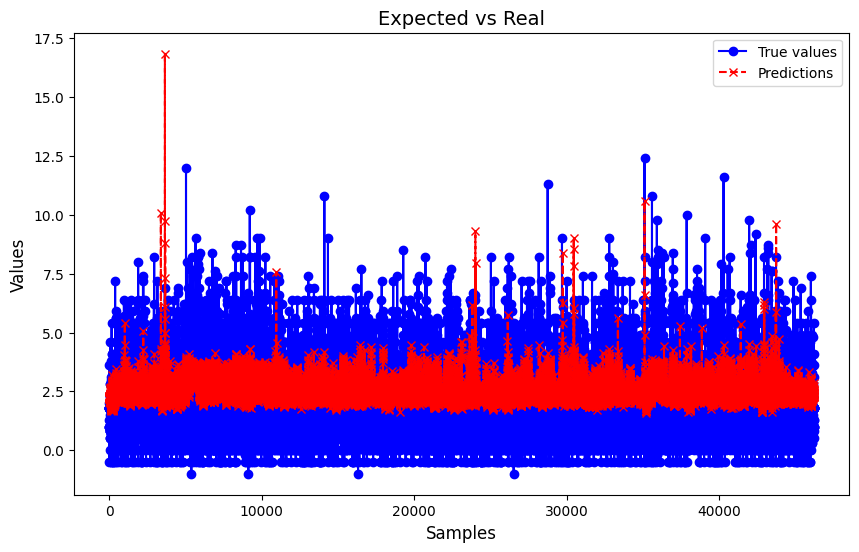

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_test, label='True values', color='blue', linestyle='-', marker='o')
plt.plot(predictions, label='Predictions', color='red', linestyle='--', marker='x')

plt.title('Expected vs Real', fontsize=14)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Values', fontsize=12)

plt.legend()

plt.show()


# Symulacja eksperymentu na danych produkcyjnych

## Rzeczywisty ostatni weekly_score który mamy przewidzieć

In [33]:
# grupowanie danych, aby dla każdego utworu wziąć ostatni znany weekly_popularity_score
latest_scores = tracks_with_score.sort_values(by='week').groupby('id').last().reset_index()

# łączenie danych z informacją o nazwach utworów
tracks_with_latest_scores = pd.merge(
    latest_scores, 
    tracks_data[['id', 'name']],  # Zakładamy, że kolumna z nazwą utworu to 'name'
    left_on='id', 
    right_on='id',
    how='left'
)

# zapisanie wyników do pliku CSV
tracks_with_latest_scores.to_csv('latest_weekly_scores.csv', index=False)

# sortowanie według weekly_popularity_score i wybór 50 najbardziej popularnych utworów
top_50_tracks_real = tracks_with_latest_scores.sort_values(by='weekly_popularity_score', ascending=False).head(50)

# wyświetlenie 50 najbardziej popularnych utworów
print("\nTop 50 najbardziej popularnych utworów na podstawie ostatniego znanego wyniku weekly_popularity_score:")
print(top_50_tracks_real[['id', 'name', 'weekly_popularity_score', 'week']])

# sortowanie według weekly_popularity_score i wybór 100 najbardziej popularnych utworów
top_100_tracks_real = tracks_with_latest_scores.sort_values(by='weekly_popularity_score', ascending=False).head(100)

# wyświetlenie 50 najbardziej popularnych utworów
print("\nTop 100 najbardziej popularnych utworów na podstawie ostatniego znanego wyniku weekly_popularity_score:")
print(top_100_tracks_real[['id', 'name', 'weekly_popularity_score', 'week']])



Top 50 najbardziej popularnych utworów na podstawie ostatniego znanego wyniku weekly_popularity_score:
                           id                                      name  \
5255   3ZCTVFBt2Brf31RLEnCkWJ                       everything i wanted   
4286   2tnVG71enUj33Ic2nFN6kZ                                   Ride It   
9112   6Im9k8u9iIzKMrmV7BWtlF                                     34+35   
8730   61KpQadow081I2AsbeLcsb                                      None   
751    0VjIjW4GlUZAMYd2vXMi3b                           Blinding Lights   
6004   45S5WTQEGOB1VHr1Q4FuPl                                    Golden   
10914  7qiZfU4dY1lWllzX7mPBI3                              Shape of You   
8588   5vGLcdRuSbUhD8ScwsGSdA                                   Whoopty   
6160   4C6BlqqMwjFzOXzqpTeoWR                              Ponte Pa' Mi   
7262   4xqrdfXkTW4T0RauPLv3WA                                   Heather   
9141   6K4t31amVTZDgR3sKmwUJJ                The Less I Know The Better

## Usunięcie z danych ostatniego weekly_score

In [22]:
import numpy as np
import pandas as pd

# usuwanie najnowszego tygodnia dla każdego utworu
def remove_latest_data(data):
    data_sorted = data.sort_values(by='week')
    data_without_latest = data_sorted.groupby('id').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
    return data_without_latest

# usunięcie najnowszych danych
tracks_without_latest_score = remove_latest_data(tracks_with_score)

# wyświetlenie liczby wierszy przed i po usunięciu
print(f"Liczba wierszy przed usunięciem: {len(tracks_with_score)}")
print(f"Liczba wierszy po usunięciu: {len(tracks_without_latest_score)}")

# dla weryfikacji: pobieramy dane, które zostały usunięte (najnowsze tygodnie)
latest_scores_removed = tracks_with_score.sort_values(by='week').groupby('id').last().reset_index()

print("\nDane, które zostały usunięte (ostatni znany weekly_popularity_score dla każdego utworu):")
print(latest_scores_removed)

tracks_without_latest_score.to_csv('tracks_without_latest_score.csv', index=False)


latest_scores_removed_with_names = pd.merge(
    latest_scores_removed, 
    tracks_data[['id', 'name']],  # zakładamy, że kolumna z nazwą utworu to 'name'
    left_on='id', 
    right_on='id',
    how='left'
)

latest_scores_removed_with_names.to_csv('latest_scores_removed.csv', index=False)

print("\nDane po usunięciu najnowszych tygodni:")
print(tracks_without_latest_score.head())


Liczba wierszy przed usunięciem: 231048
Liczba wierszy po usunięciu: 219920

Dane, które zostały usunięte (ostatni znany weekly_popularity_score dla każdego utworu):
                           id  duration_ms  danceability  energy  popularity  \
0      003FTlCpBTM4eSqYSWPv4H       233267         0.553   0.717        69.0   
1      003vvx7Niy0yvhvHt4a68B       222973         0.352   0.911        82.0   
2      005Dlt8Xaz3DkaXiRJgdiS       405120         0.715   0.621        66.0   
3      005lwxGU1tms6HGELIcUv9       179640         0.699   0.760        71.0   
4      009ImBOrIUlWgla8U05RAC       228879         0.432   0.725        73.0   
...                       ...          ...           ...     ...         ...   
11123  7zuwr7YqqpveNtxlKe1vn6       283893         0.609   0.607        64.0   
11124  7zv5oGRQoJX09QM3pkvI1w       277827         0.426   0.687        51.0   
11125  7zwn1eykZtZ5LODrf7c0tS       153000         0.551   0.881        71.0   
11126  7zycSpvjDcqh6YT1FEl2kY     

## Uzyskiwanie wyników

In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler

input_features = [
    'id_artist_encoded', 'duration_ms', 'danceability', 'energy', 
    'popularity', 'speechiness', 'acousticness', 'instrumentalness', 'release_year', 'weekly_popularity_score'
]

output_column = 'weekly_popularity_score'

scaler = StandardScaler()
scaled_features = scaler.fit_transform(tracks_without_latest_score[input_features])

n_time_steps = 4  # liczba poprzednich tygodni

X = []
y = []

track_weeks_info = []

tracks_grouped = tracks_without_latest_score.groupby('id')

for track_id, track_data in tracks_grouped:
    if len(track_data) >= n_time_steps:
        # wybierz ostatnią sekwencję (ostatnie 4 tygodnie)
        track_sequence = track_data.tail(n_time_steps)
        
        sequence = scaled_features[track_sequence.index]
        X.append(sequence)
        
        y.append(track_data[output_column].iloc[-1])  # Używamy ostatniej wartości 'weekly_popularity_score' dla danego utworu
        
        weeks = track_sequence['week'].values
        track_weeks_info.append((track_id, weeks))

X_latest = np.array(X)
y = np.array(y)

print(X_latest.shape)  # (samples, time_steps, features)
print(y.shape)  # (samples,)

with open("track_weeks_info.txt", "w") as f:
    for track_id, weeks in track_weeks_info:
        f.write(f"Track ID: {track_id}, Weeks: {', '.join(map(str, weeks))}\n")

print("Informacje o tygodniach zostały zapisane do pliku 'track_weeks_info.txt'.")


(10995, 4, 10)
(10995,)
Informacje o tygodniach zostały zapisane do pliku 'track_weeks_info.txt'.


In [24]:
print(X_latest.shape)

(10995, 4, 10)


In [25]:
predictions = model.predict(X_latest)

344/344 [==============================] - 3s 4ms/step


In [26]:
print(len(predictions))

10995


In [27]:
print(predictions)

[[2.7872996]
 [2.607141 ]
 [2.3740091]
 ...
 [2.374115 ]
 [2.1270156]
 [2.124423 ]]


In [28]:
track_predictions = []

for idx, (track_id, _) in enumerate(track_weeks_info):
    track_predictions.append((track_id, predictions[idx]))

sorted_predictions = sorted(track_predictions, key=lambda x: x[1], reverse=True)

top_50_tracks_predicted = sorted_predictions[:50]

with open("top_50_tracks_predictions.txt", "w") as f:
    for track_id, prediction in top_50_tracks_predicted:
        f.write(f"Track ID: {track_id}, Predicted Popularity: {prediction}\n")

# Zapisz wyniki dla wszystkich utworów do pliku
with open("all_tracks_predictions.txt", "w") as f:
    for track_id, prediction in sorted_predictions:
        f.write(f"Track ID: {track_id}, Predicted Popularity: {prediction}\n")

print("Wszystkie utwory oraz 50 najbardziej popularnych zostały zapisane do plików 'all_tracks_predictions.txt' i 'top_50_tracks_predictions.txt'.")


Wszystkie utwory oraz 50 najbardziej popularnych zostały zapisane do plików 'all_tracks_predictions.txt' i 'top_50_tracks_predictions.txt'.


# Ocena otrzymanych danych


### Na 50

In [29]:
predicted_ids = {track_id for track_id, _ in top_50_tracks_predicted}

actual_ids =  top_50_tracks_real['id']

common_ids = predicted_ids.intersection(actual_ids)

num_common = len(common_ids)

print(f"Liczba wspólnych ID: {num_common}")
print(common_ids)


Liczba wspólnych ID: 29
{'1diS6nkxMQc3wwC4G1j0bh', '285pBltuF7vW8TeWk8hdRR', '31qCy5ZaophVA81wtlwLc4', '7fBv7CLKzipRk6EC6TWHOB', '55Am8neGJkdj2ADaM3aw5H', '3U4isOIWM3VvDubwSI3y7a', '3FAJ6O0NOHQV8Mc5Ri6ENp', '3UHPGOkUcE4hE7sqBF4Snt', '54bFM56PmE4YLRnqpW6Tha', '61KpQadow081I2AsbeLcsb', '249gnXrbfmV8NG6jTEMSwD', '7lPN2DXiMsVn7XUKtOW1CS', '6AGOKlMZWLCaEJGnaROtF9', '6tDDoYIxWvMLTdKpjFkc1B', '3eekarcy7kvN4yt5ZFzltW', '0VjIjW4GlUZAMYd2vXMi3b', '7qiZfU4dY1lWllzX7mPBI3', '7MiZjKawmXTsTNePyTfPyL', '2b8fOow8UzyDFAE27YhOZM', '4xqrdfXkTW4T0RauPLv3WA', '7m9OqQk4RVRkw9JJdeAw96', '6ocbgoVGwYJhOv1GgI9NsF', '0ofHAoxe9vBkTCp2UQIavz', '696DnlkuDOXcMAnKlTgXXK', '2gMXnyrvIjhVBUZwvLZDMP', '7qEHsqek33rTcFNT9PFqLf', '21jGcNKet2qwijlDFuPiPb', '5E30LdtzQTGqRvNd7l6kG5', '2ZRo7axmMPeSVUvDbGkJah'}


In [30]:
num_predicted = len(predicted_ids)
percentage_popular = (num_common / num_predicted) * 100

print(f"Procent zaproponowanych utworów, które były popularne: {percentage_popular:.2f}%")


Procent zaproponowanych utworów, które były popularne: 58.00%


In [31]:
print(predicted_ids)

{'3Ofmpyhv5UAQ70mENzB277', '58pgi1RpcU2fVJsxhm7BIr', '27OeeYzk6klgBh83TSvGMA', '1diS6nkxMQc3wwC4G1j0bh', '285pBltuF7vW8TeWk8hdRR', '31qCy5ZaophVA81wtlwLc4', '7fBv7CLKzipRk6EC6TWHOB', '5RubKOuDoPn5Kj5TLVxSxY', '55Am8neGJkdj2ADaM3aw5H', '1Xi84slp6FryDSCbzq4UCD', '3U4isOIWM3VvDubwSI3y7a', '2ZRo7axmMPeSVUvDbGkJah', '3FAJ6O0NOHQV8Mc5Ri6ENp', '2mt1IqcFyY1zmYZT8Q3xw9', '3UHPGOkUcE4hE7sqBF4Snt', '54bFM56PmE4YLRnqpW6Tha', '61KpQadow081I2AsbeLcsb', '7qEHsqek33rTcFNT9PFqLf', '3ee8Jmje8o58CHK66QrVC2', '249gnXrbfmV8NG6jTEMSwD', '7lPN2DXiMsVn7XUKtOW1CS', '6tDDoYIxWvMLTdKpjFkc1B', '2XU0oxnq2qxCpomAAuJY8K', '1tkg4EHVoqnhR6iFEXb60y', '6AGOKlMZWLCaEJGnaROtF9', '3YJJjQPAbDT7mGpX3WtQ9A', '43zdsphuZLzwA9k4DJhU0I', '1nahzW3kfMuwReTka28tH5', '7uoFMmxln0GPXQ0AcCBXRq', '30bqVoKjX479ab90a8Pafp', '0VjIjW4GlUZAMYd2vXMi3b', '7qiZfU4dY1lWllzX7mPBI3', '60ynsPSSKe6O3sfwRnIBRf', '7MiZjKawmXTsTNePyTfPyL', '45bE4HXI0AwGZXfZtMp8JR', '2b8fOow8UzyDFAE27YhOZM', '4xqrdfXkTW4T0RauPLv3WA', '7m9OqQk4RVRkw9JJdeAw96', '6ocbgoVGwY

In [32]:
print(actual_ids)

5255     3ZCTVFBt2Brf31RLEnCkWJ
4286     2tnVG71enUj33Ic2nFN6kZ
9112     6Im9k8u9iIzKMrmV7BWtlF
8730     61KpQadow081I2AsbeLcsb
751      0VjIjW4GlUZAMYd2vXMi3b
6004     45S5WTQEGOB1VHr1Q4FuPl
10914    7qiZfU4dY1lWllzX7mPBI3
8588     5vGLcdRuSbUhD8ScwsGSdA
6160     4C6BlqqMwjFzOXzqpTeoWR
7262     4xqrdfXkTW4T0RauPLv3WA
9141     6K4t31amVTZDgR3sKmwUJJ
10908    7qEHsqek33rTcFNT9PFqLf
9599     6f3Slt0GbA2bPZlz0aIFXN
2246     1VLtjHwRWOVJiE5Py7JxoQ
3905     2dl5K2ScW7jYhAhuem06cm
3663     2U5WueTLIK5WJLD7mvDODv
4805     3FAJ6O0NOHQV8Mc5Ri6ENp
2278     1XXimziG1uhM0eDNCZCrUl
2992     21jGcNKet2qwijlDFuPiPb
3799     2ZRo7axmMPeSVUvDbGkJah
3147     285pBltuF7vW8TeWk8hdRR
3850     2b8fOow8UzyDFAE27YhOZM
2415     1diS6nkxMQc3wwC4G1j0bh
10269    79s5XnCN4TJKTVMSmOx8Ep
9802     6ocbgoVGwYJhOv1GgI9NsF
10664    7fBv7CLKzipRk6EC6TWHOB
7141     4saklk6nie3yiGePpBwUoc
5519     3jjujdWJ72nww5eGnfs2E7
10969    7szuecWAPwGoV1e5vGu8tl
5144     3UHPGOkUcE4hE7sqBF4Snt
7431     55Am8neGJkdj2ADaM3aw5H
3984    

### Na 100

In [35]:
predicted_ids = {track_id for track_id, _ in top_50_tracks_predicted}

actual_ids =  top_100_tracks_real['id']

common_ids = predicted_ids.intersection(actual_ids)

num_common = len(common_ids)

print(f"Liczba wspólnych ID: {num_common}")
print(common_ids)


Liczba wspólnych ID: 48
{'3Ofmpyhv5UAQ70mENzB277', '58pgi1RpcU2fVJsxhm7BIr', '1diS6nkxMQc3wwC4G1j0bh', '27OeeYzk6klgBh83TSvGMA', '285pBltuF7vW8TeWk8hdRR', '31qCy5ZaophVA81wtlwLc4', '7fBv7CLKzipRk6EC6TWHOB', '5RubKOuDoPn5Kj5TLVxSxY', '55Am8neGJkdj2ADaM3aw5H', '1Xi84slp6FryDSCbzq4UCD', '3U4isOIWM3VvDubwSI3y7a', '2mt1IqcFyY1zmYZT8Q3xw9', '3FAJ6O0NOHQV8Mc5Ri6ENp', '3UHPGOkUcE4hE7sqBF4Snt', '54bFM56PmE4YLRnqpW6Tha', '61KpQadow081I2AsbeLcsb', '3ee8Jmje8o58CHK66QrVC2', '249gnXrbfmV8NG6jTEMSwD', '7lPN2DXiMsVn7XUKtOW1CS', '6AGOKlMZWLCaEJGnaROtF9', '6tDDoYIxWvMLTdKpjFkc1B', '3eekarcy7kvN4yt5ZFzltW', '1tkg4EHVoqnhR6iFEXb60y', '2XU0oxnq2qxCpomAAuJY8K', '43zdsphuZLzwA9k4DJhU0I', '1nahzW3kfMuwReTka28tH5', '7uoFMmxln0GPXQ0AcCBXRq', '0VjIjW4GlUZAMYd2vXMi3b', '7qiZfU4dY1lWllzX7mPBI3', '60ynsPSSKe6O3sfwRnIBRf', '7MiZjKawmXTsTNePyTfPyL', '45bE4HXI0AwGZXfZtMp8JR', '2b8fOow8UzyDFAE27YhOZM', '4xqrdfXkTW4T0RauPLv3WA', '7m9OqQk4RVRkw9JJdeAw96', '6ocbgoVGwYJhOv1GgI9NsF', '1ZMiCix7XSAbfAJlEZWMCp', '0ofHAoxe9vBk

In [37]:
num_predicted = len(predicted_ids)
percentage_popular = (num_common / num_predicted) * 100

print(f"Procent zaproponowanych utworów, które były popularne w top 100: {percentage_popular:.2f}%")


Procent zaproponowanych utworów, które były popularne w top 100: 96.00%
